# Fall Detection using SisFall Dataset
Daniela Dias, nMec 98039

In [1]:
# General-purpose libraries
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.fft import fft

# Scikit-learn: preprocessing, models, evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight

# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics and visualization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Hyperparameter optimization
import optuna

# Model persistence
import joblib

# from plot_utils import optuna_visualizations, confusion_matrix_plot, roc_curve_plot, precision_recall_plot

## Utility Functions

In [2]:
# Plotting and visualization
import matplotlib.pyplot as plt
import optuna.visualization as vis

# Scikit-learn metrics and visualizations
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)


def optuna_visualizations(study, params):
    # Visualize the hyperparameter combinations and their performance
    fig = vis.plot_contour(study, params=params)
    fig.show()

    # Visualize the optimization history
    fig = vis.plot_optimization_history(study)
    fig.show()

    # Visualize the parameter importance
    fig = vis.plot_param_importances(study)
    fig.show()


def precision_recall_plot(y_test, y_pred, title):
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve', color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()


def confusion_matrix_plot(y_test, y_pred, title):
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Fall", "Fall"])
    disp.plot(cmap='Blues')
    disp.ax_.set_title(title)
    disp.ax_.set_xlabel("Predicted")
    disp.ax_.set_ylabel("True")
    disp.figure_.set_size_inches(8, 6)
    disp.figure_.tight_layout()
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def roc_curve_plot(y_test, y_proba, title):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc), color='blue')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

## Traditional Machine Learning Preprocessing

The preprocessing pipeline for traditional machine learning begins by converting raw sensor data into numerical features that summarize activity windows.

1. Raw signal data is segmented into overlapping windows of fixed length (e.g., 2 seconds = 400 samples at 200 Hz).
   - Each window is treated as a single sample.
   - The overlap can be adjusted (e.g., 25% overlap).
2. For each window, both time-domain and frequency-domain features are extracted:
   - Time-domain: mean, standard deviation, min, max, median, skewness, kurtosis.
   - Frequency-domain: FFT mean, standard deviation, max, and energy.
3. Each window is labeled based on the most frequent label within it.
4. Features are normalized using z-score standardization based on the training set.
5. SMOTE (Synthetic Minority Oversampling Technique) is applied to the training data to address class imbalance between falls and ADLs.
6. Subject-wise splitting is used to ensure no overlap of subjects between training and testing sets.


### Avoiding Subject Bias in Train-Test Split

When working with the SisFall dataset (or any dataset where multiple recordings come from the same individuals), it is essential to avoid data leakage caused by random sample splitting. 

If we randomly split the dataset into training and testing sets, we risk placing samples from the same subject in both sets. This introduces what is known as "subject bias" — the model can inadvertently learn personal characteristics or movement patterns of specific individuals rather than learning to generalize fall detection across new, unseen people. This would artificially inflate evaluation metrics (such as accuracy and F1-score), because the model is partially memorizing rather than generalizing.

To address this, we use a subject-wise splitting strategy:  
- We first extract the list of unique subjects.  
- Then we split these subjects into train and test groups.  
- Finally, we assign samples based on the subject to which they belong.

This ensures that the model is evaluated on entirely unseen individuals, simulating real-world scenarios where fall detection must work for new users. It leads to more honest and generalizable performance metrics.

In [3]:
# Load the dataset from CSV file
sisfall_data = pd.read_csv('/kaggle/input/sisfall/reduced_sisfall_dataset.csv')

In [4]:
# Feature extraction function with frequency-domain features
def extract_features(df, window_size=800, overlap=0.50, variance_threshold=0.1):
    # Calculate the step size based on the window size and overlap
    step = int(window_size * (1 - overlap))

    # Obtain the sensor columns
    sensor_cols = df.columns[:-3]  # Exclude label, filename, subject

    # Generate feature names (only once)
    feature_names = []
    for col in sensor_cols:
        feature_names.extend([
            f'{col}_mean', f'{col}_std', f'{col}_min', f'{col}_max',
            f'{col}_median', f'{col}_skew', f'{col}_kurt',
            f'{col}_fft_mean', f'{col}_fft_std', f'{col}_fft_max', f'{col}_fft_energy'
        ])

    all_features = []
    all_labels = []

    for filename, group in df.groupby('filename'):
        group = group.reset_index(drop=True)
        for start in range(0, len(group) - window_size + 1, step):
            window = group.iloc[start:start + window_size]
            feature_vector = []

            # Check if the variance of the window is above the threshold
            if window[sensor_cols].var().max() < variance_threshold:
                continue  # Skip this window if variance is too low

            # Extract features and labels
            for col in sensor_cols:
                data = pd.to_numeric(window[col], errors='coerce').fillna(0).values

                # Time-domain features
                feature_vector.extend([
                    data.mean(), data.std(), data.min(), data.max(),
                    np.median(data), skew(data), kurtosis(data)
                ])

                # Frequency-domain features
                fft_values = np.abs(fft(data))
                feature_vector.extend([
                    fft_values.mean(), fft_values.std(), fft_values.max(),
                    np.sum(fft_values ** 2) / len(fft_values)
                ])

            label = window['label'].mode()[0]  # Most frequent label in the window
            all_features.append(feature_vector)
            all_labels.append(label)

    return pd.DataFrame(all_features, columns=feature_names), np.array(all_labels), feature_names


In [5]:
# Preprocessing function to handle class imbalance and scaling
def preprocess_data(df):
    # Extract unique subjects
    subjects = df['subject'].unique()

    # Subject-wise split
    train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, random_state=42)

    # Assign samples based on subject
    train_data = df[df['subject'].isin(train_subjects)]
    test_data = df[df['subject'].isin(test_subjects)]

    # Extract features from training and testing data
    X_train, y_train, feature_names = extract_features(train_data)
    X_test, y_test, _ = extract_features(test_data)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Map labels to numeric (binary classification)
    label_map = {'adl': 0, 'fall': 1}
    y_train = pd.Series(y_train).map(label_map)
    y_test = pd.Series(y_test).map(label_map)

    return X_train, y_train, X_test, y_test

In [6]:
# Preprocess the dataset
X_train, y_train, X_test, y_test = preprocess_data(sisfall_data)

In [7]:
# Check the shape of the training and testing sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9900, 99), (9900,), (2444, 99), (2444,))

## Evaluation Metrics

Model performance was assessed using multiple metrics, including accuracy, precision, recall, F1-score, and ROC-AUC. These metrics comprehensively evaluate the model's ability to identify fall incidents while minimizing false alarms correctly, a critical balance in fall detection applications.

In [8]:
N_TRIALS = 10

In [9]:
def run_model(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train.values.ravel())

    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_proba)

    print("Test Accuracy:", test_accuracy)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test F1-score:", test_f1)
    print("Test AUC:", test_auc)

    return y_pred, y_proba

## Support Vector Machine (SVM)

The Support Vector Machine (SVM) model was employed as a classical baseline to evaluate the performance of traditional machine learning methods in fall detection using wearable sensor data. SVM is particularly well-suited for binary classification tasks and works by finding the optimal hyperplane that maximally separates the two classes (fall vs. non-fall) in a high-dimensional feature space.

* **Kernel Functions**: Both linear and radial basis function (RBF) kernels were considered. The RBF kernel allows the model to capture non-linear decision boundaries, which is beneficial for complex sensor data.
* **Regularization (C)**: Controls the trade-off between achieving a low training error and a low testing error (generalization). Smaller values of C result in a wider margin, while larger values aim to classify training examples more accurately.
* **Gamma**: Defines the influence of a single training example. Low gamma values consider points far away from the decision boundary, whereas high gamma values focus more on close points.

The model was trained using features extracted from segmented sensor windows, and class imbalance was handled by computing class weights. Hyperparameters including the regularization parameter `C`, kernel type, and `gamma` were optimized using the Optuna framework. Stratified K-Fold cross-validation ensured robust evaluation across different folds, and model performance was assessed using the macro-averaged F1-score.


In [11]:
def svm_objective(trial):
    # Hyperparameter search space
    C = trial.suggest_float('C', 1e-5, 1e3, log=True)
    gamma = trial.suggest_float('gamma', 1e-5, 1e1, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Compute class weights to handle imbalance
        class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
        class_weight_dict = dict(zip(np.unique(y_tr), class_weights))

        # Initialize SVM model with suggested hyperparameters
        svm = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weight_dict, probability=True, random_state=42)

        # Train the model
        svm.fit(X_tr, y_tr)

        # Predict and evaluate on validation set
        y_pred = svm.predict(X_val)
        fold_f1 = f1_score(y_val, y_pred, average='macro')
        scores.append(fold_f1)

    # Return mean F1-score across folds
    return np.mean(scores)

In [16]:
# Create a study object and optimize the objective function
svm_study = optuna.create_study(direction='maximize')
svm_study.optimize(svm_objective, n_trials=N_TRIALS)

[I 2025-05-07 13:48:03,714] A new study created in memory with name: no-name-817e34ce-ba0e-4b56-b918-bdf6a35e2388
[I 2025-05-07 13:48:21,778] Trial 0 finished with value: 0.843043852172633 and parameters: {'C': 0.007683377114805858, 'gamma': 0.00030797493241341647, 'kernel': 'linear'}. Best is trial 0 with value: 0.843043852172633.
[I 2025-05-07 13:49:15,356] Trial 1 finished with value: 0.8122966085699019 and parameters: {'C': 0.005274726922686116, 'gamma': 0.013995581123450418, 'kernel': 'rbf'}. Best is trial 0 with value: 0.843043852172633.
[I 2025-05-07 13:50:13,434] Trial 2 finished with value: 0.8699399840421238 and parameters: {'C': 1.7637705338263308, 'gamma': 0.44921126633713643, 'kernel': 'rbf'}. Best is trial 2 with value: 0.8699399840421238.
[I 2025-05-07 13:50:38,199] Trial 3 finished with value: 0.8221078182436256 and parameters: {'C': 0.00012514537237955648, 'gamma': 8.976790083516874e-05, 'kernel': 'linear'}. Best is trial 2 with value: 0.8699399840421238.
[I 2025-05-07

In [17]:
# Print the best hyperparameters and the corresponding F1 score
print("Best hyperparameters: ", svm_study.best_params)
print("Best F1 score: ", svm_study.best_value)

Best hyperparameters:  {'C': 42.64290809813442, 'gamma': 0.016108771439478555, 'kernel': 'rbf'}
Best F1 score:  0.9417246428848719


In [18]:
# Visualize optuna results
optuna_visualizations(svm_study, ["C", "gamma", "kernel"])

In [13]:
# Run the SVM model with the best hyperparameters
best_svm_model = SVC(**svm_study.best_params, probability=True)
y_pred, y_proba = run_model(best_svm_model, X_train, y_train, X_test, y_test)

Test Accuracy: 0.9030278232405892
Test Precision: 0.8800755429650614
Test Recall: 0.8944337811900192
Test F1-score: 0.8871965730604473
Test AUC: 0.9507448914492869


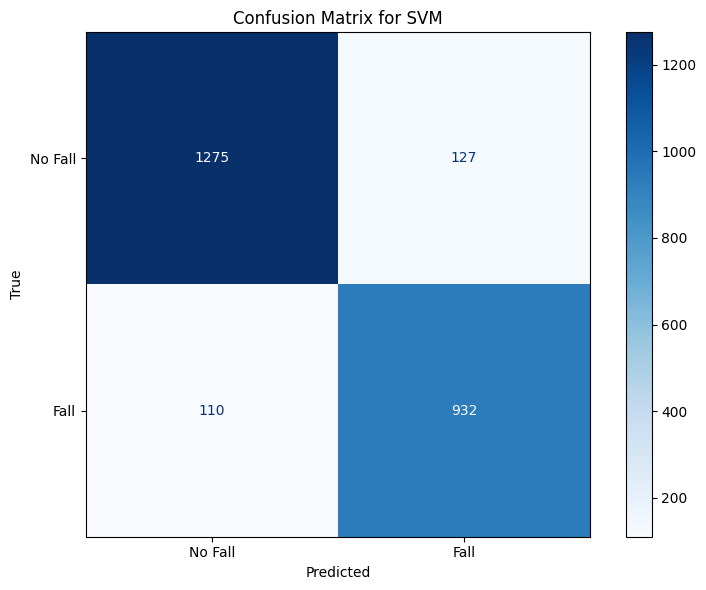

In [14]:
# Plot confusion matrix
confusion_matrix_plot(y_test, y_pred, "Confusion Matrix for SVM")

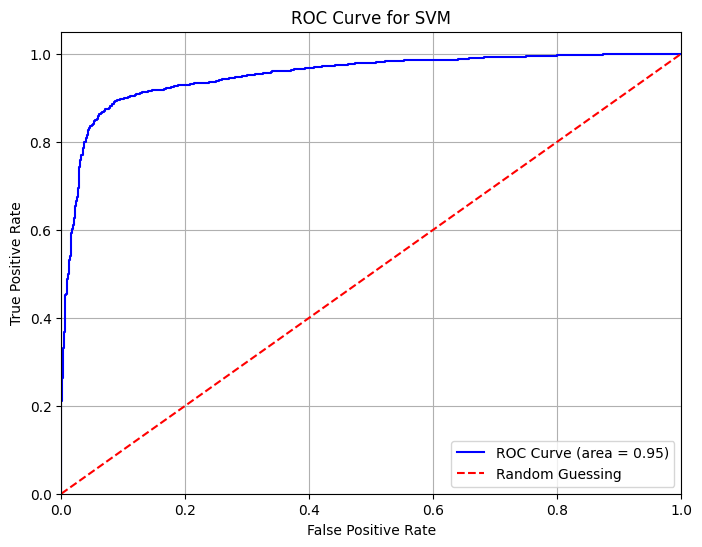

In [15]:
# Plot ROC curve
roc_curve_plot(y_test, y_proba, "ROC Curve for SVM")

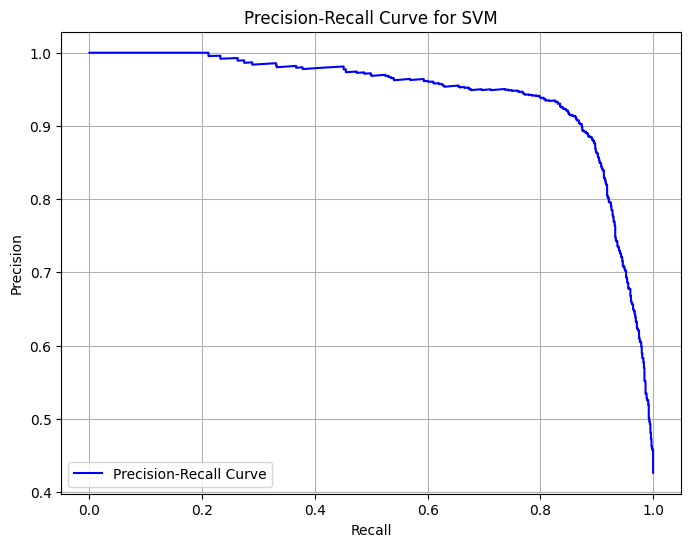

In [16]:
# Plot Recall-Precision curve
precision_recall_plot(y_test, y_proba, "Precision-Recall Curve for SVM")

In [17]:
# Save the model
joblib.dump(best_svm_model, 'best_svm_model.pkl')

['best_svm_model.pkl']

## Random Forest

The Random Forest model was employed as a classical ensemble-based approach for fall detection. It combines multiple decision trees to improve predictive performance and generalization by reducing overfitting, which is common in single decision trees.

* **Ensemble of Decision Trees**: The model consists of multiple decision trees trained on different subsets of the training data with replacement (bootstrap sampling). Each tree votes on the final classification, and the majority vote is used as the final output.
* **Feature Subsampling**: At each split in a tree, a random subset of features is considered, promoting diversity among the trees and reducing correlation between them.

To address the class imbalance typical in fall datasets, class weights were computed and applied to ensure the minority class (falls) was properly represented during training.

Key hyperparameters, including the number of trees (`n_estimators`), maximum tree depth (`max_depth`), and minimum samples per split and leaf, were optimized using the Optuna framework. The model was evaluated using Stratified K-Fold cross-validation, and performance was measured using the ROC AUC score based on predicted probabilities for the positive class.

In [19]:
def rf_objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Class weight balancing
        class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
        class_weight_dict = dict(zip(np.unique(y_tr), class_weights))

        # Model definition
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            class_weight=class_weight_dict,
            random_state=42,
            n_jobs=-1
        )

        # Train the model
        rf.fit(X_tr, y_tr)

        # Predict and evaluate on validation set
        y_pred = rf.predict(X_val)
        fold_f1 = f1_score(y_val, y_pred, average='macro')
        scores.append(fold_f1)

    # Return mean F1-score across folds
    return np.mean(scores)

In [23]:
# Create a study object and optimize the objective function
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=N_TRIALS)

[I 2025-05-07 19:11:34,067] A new study created in memory with name: no-name-ee39e30d-32f4-41f6-bd4c-fe44b898cd51
[I 2025-05-07 19:15:00,833] Trial 0 finished with value: 0.9314193181675003 and parameters: {'n_estimators': 402, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.9314193181675003.
[I 2025-05-07 19:15:06,191] Trial 1 finished with value: 0.9383911923394742 and parameters: {'n_estimators': 150, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.9383911923394742.
[I 2025-05-07 19:19:08,118] Trial 2 finished with value: 0.9334671913245137 and parameters: {'n_estimators': 436, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9383911923394742.
[I 2025-05-07 19:19:19,330] Trial 3 finished with value: 0.9417595410531646 and parameters: {'n_estimators': 312, 'max_depth': 40, 'min_

In [24]:
# Print the best hyperparameters and the corresponding AUC score
print("Best hyperparameters: ", rf_study.best_params)
print("Best F1 score: ", rf_study.best_value)

Best hyperparameters:  {'n_estimators': 190, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best F1 score:  0.9436172128689125


In [25]:
# Visualize optuna results
optuna_visualizations(rf_study, ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "max_features"])

In [11]:
# Run the Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(**rf_study.best_params, random_state=42, n_jobs=-1)
y_pred, y_proba = run_model(best_rf_model, X_train, y_train, X_test, y_test)

Test Accuracy: 0.9108019639934534
Test Precision: 0.8879472693032016
Test Recall: 0.9049904030710173
Test F1-score: 0.8963878326996199
Test AUC: 0.9707957647561339


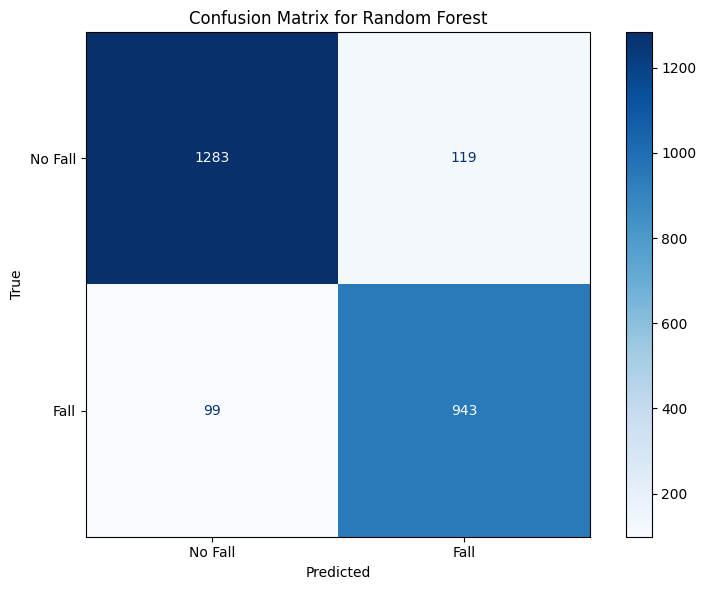

In [13]:
# Plot confusion matrix
confusion_matrix_plot(y_test, y_pred, "Confusion Matrix for Random Forest")

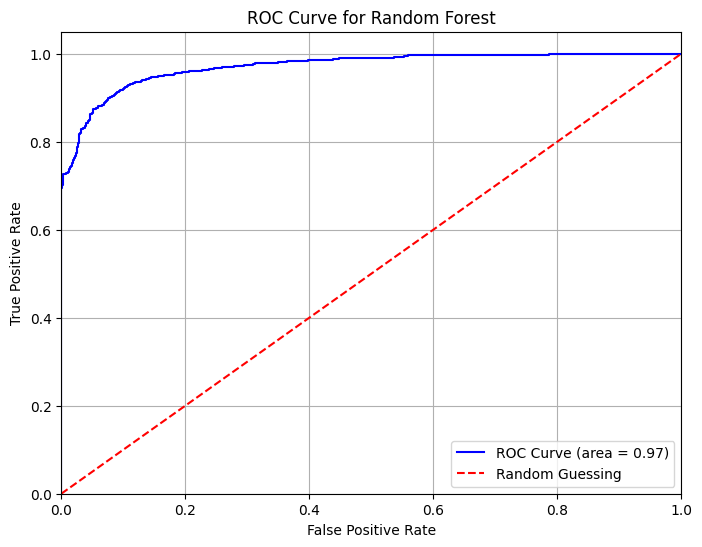

In [14]:
# Plot ROC curve
roc_curve_plot(y_test, y_proba, "ROC Curve for Random Forest")

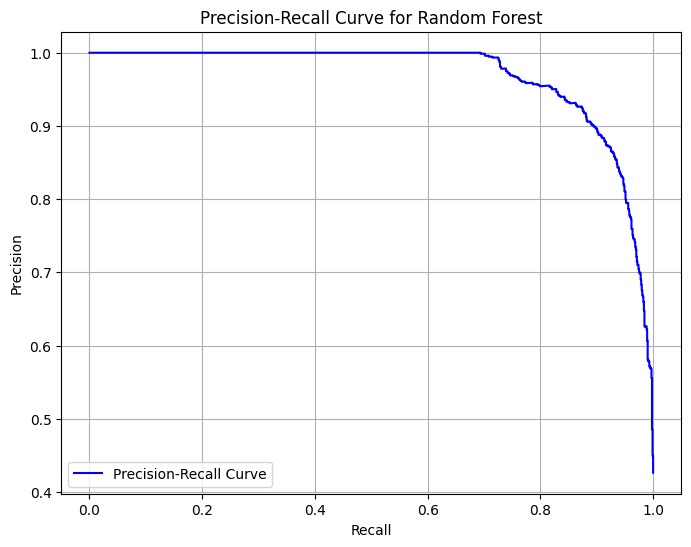

In [15]:
# Plot Recall-Precision curve
precision_recall_plot(y_test, y_proba, "Precision-Recall Curve for Random Forest")

In [16]:
# Save the model
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']